In [75]:
import pandas as pd
path = "/Users/filipecarvalho/Documents/data_science_projects/antónio/data_filtered_and_imputed.csv"
df = pd.read_csv(path)
# Converte colunas de tipo object para category
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

In [76]:
import pandas as pd

# Definir os limites das categorias
limits = [0,1,4,6,1000]

# Definir os rótulos das categorias
labels = [1,2,3,4]

# Criar a coluna com as categorias
df["DIAS PRE OP_label"] = pd.cut(df["DIAS PRE OP"], bins=limits, labels=labels, right=False)

In [77]:

# Calculate the quartiles on the numeric column
quartiles = df['IDADE'].quantile([0.25, 0.5, 0.80, 1.0])
import pandas as pd
# Definir os rótulos para os quartis
labels = ['Q1', 'Q2', 'Q3', 'Q4']
# Criar uma nova coluna com os rótulos dos quartis
df['IDADE_label'] = pd.cut(df['IDADE'], bins=[-float('inf')] + list(quartiles), labels=labels, include_lowest=True)
# Verify if the date belongs to the top quartile
df['4_IDADE'] = df['IDADE'] > quartiles[0.80]

# Ensure the categorical columns are converted to the correct type
df['OBITO'] = df['OBITO'].astype(bool)
df['RISCO ANEST'] = df['RISCO ANEST'].astype(str)
df['NIVEL GDH'] = df['NIVEL GDH'].astype(int)
df["RISK_DEATH"] = "Low Risk"
# Updating to High Risk
df.loc[
    (df["OBITO"])|
    df["4_IDADE"] ,
    "RISK_DEATH"
] = "High Risk"

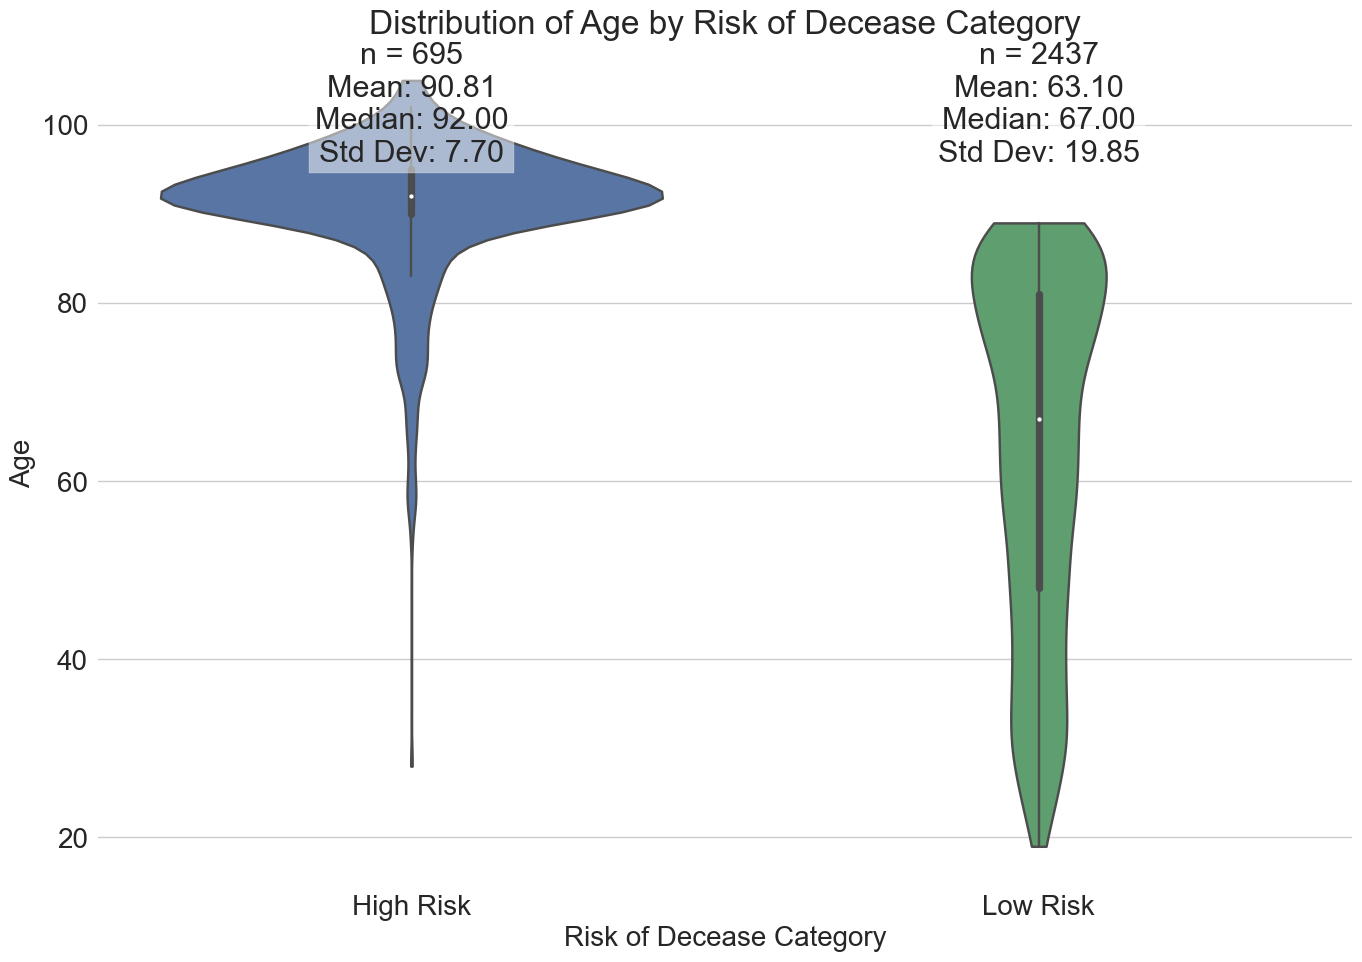

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Configurar o estilo do seaborn para um visual mais agradável
sns.set_style("whitegrid")

# Criar a figura e os eixos
plt.figure(figsize=(14, 10))

# Certifique-se de que RISK_DEATH é tratado como categórico
df['RISK_DEATH'] = df['RISK_DEATH'].astype('category')

# Criar o gráfico de violino
sns.violinplot(x="RISK_DEATH", y="IDADE", data=df, cut=0, inner="box")

# Configurar o título e os rótulos dos eixos com tamanhos maiores
plt.title("Distribution of Age by Risk of Decease Category", fontsize=24)
plt.xlabel("Risk of Decease Category", fontsize=20)
plt.ylabel("Age", fontsize=20)

# Aumentar o tamanho dos ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Adicionar estatísticas descritivas
for i, category in enumerate(df['RISK_DEATH'].cat.categories):
    subset = df[df['RISK_DEATH'] == category]['IDADE']
    count = len(subset)
    mean = np.mean(subset)
    median = np.median(subset)
    std = np.std(subset)
    
    stats_text = f'n = {count}\nMean: {mean:.2f}\nMedian: {median:.2f}\nStd Dev: {std:.2f}'
    plt.text(i, plt.ylim()[1], stats_text, 
             ha='center', va='top', fontsize=22, bbox=dict(facecolor='white', alpha=0.5))

# Ajustar o layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()

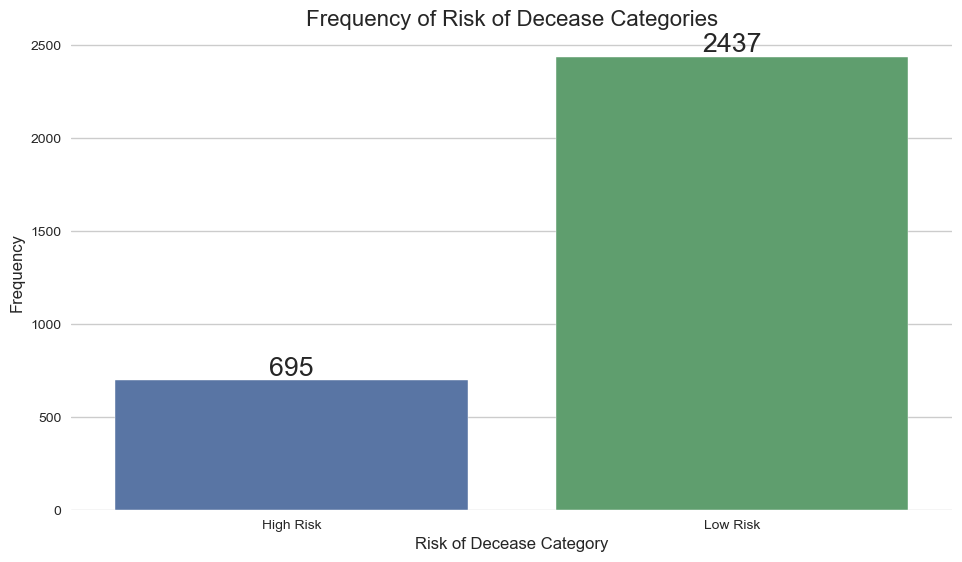

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configurar o estilo do seaborn para um visual mais agradável
sns.set_style("whitegrid")

# Criar a figura e os eixos
plt.figure(figsize=(10, 6))

# Calcular as frequências
freq = df['RISK_DEATH'].value_counts().sort_index()

# Criar o gráfico de barras
ax = sns.barplot(x=freq.index, y=freq.values)

# Adicionar rótulos nas barras
for i, v in enumerate(freq.values):
    ax.text(i, v, str(v), ha='center', va='bottom')

# Configurar o título e os rótulos dos eixos
plt.title("Frequency of Risk of Decease Categories", fontsize=16)
plt.xlabel("Risk of Decease Category", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Ajustar o layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()

In [80]:

# Assuming your dataset is in a DataFrame called 'df' with a column 'label'
df['RISK_DEATH'] = df['RISK_DEATH'].replace({'High Risk': 1, 'Low Risk': 0})

In [81]:
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier

categorical_cols = df.select_dtypes(include=['object', 'category'])#.columns.difference(exclude_cols)

# Label Encoding para colunas categóricas
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Definindo X e y para todo o dataset
X = df.drop(["RISK_DEATH", "DTA NASC_ano", "DIAS NA INSTITUICAO", "OBITO", "INT DES DESTINO", "4_IDADE"], axis=1)
y = df["RISK_DEATH"]

Xx = X.values


selected_features_indices = [  0,  42,  43,  46,  51,  61,  65,  89, 109, 116, 117]

# Usando os índices salvos para selecionar as características relevantes
X_selected = Xx[:, selected_features_indices]

# Aplicando SMOTE para balancear as classes nos dados selecionados
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Inicializando e treinando o LGBMClassifier
meta_classifier = LGBMClassifier(class_weight={0: 1, 1: 1.2}, learning_rate=0.8, max_depth=6, n_estimators=20, num_leaves=20)
meta_classifier.fit(X_resampled, y_resampled)

# Fazendo previsões para o dataset original
predictions = meta_classifier.predict(X_selected)
probabilities = meta_classifier.predict_proba(X_selected)[:, 1]  # Para classificação binária

# Adicionando as previsões ao dataframe original
df['predicted_risk'] = predictions
df['predicted_probability'] = probabilities

# Avaliação do modelo
print(classification_report(y, predictions))
print(confusion_matrix(y, predictions))
print("AUC-ROC Score:", roc_auc_score(y, probabilities))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2437
           1       0.99      0.95      0.97       695

    accuracy                           0.99      3132
   macro avg       0.99      0.97      0.98      3132
weighted avg       0.99      0.99      0.99      3132

[[2433    4]
 [  34  661]]
AUC-ROC Score: 0.9976710957864812


/Users/filipecarvalho/miniconda3/envs/tensorflow/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


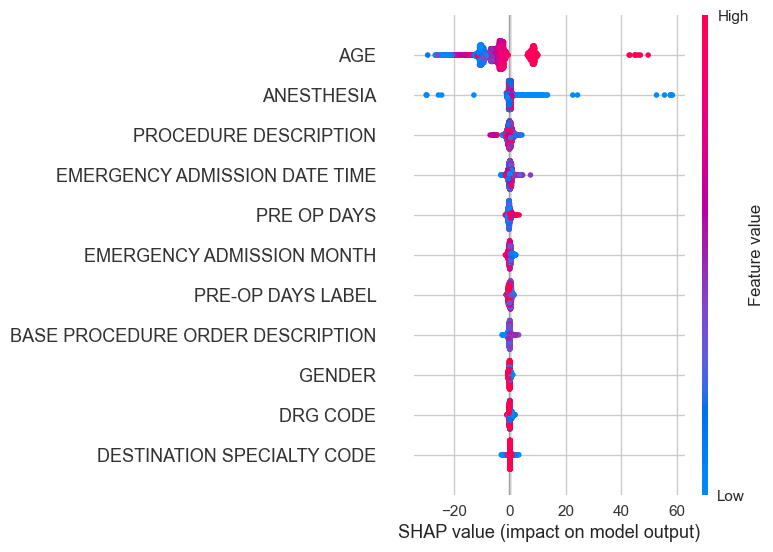

                            col_name  feature_importance_vals
0                                AGE                 6.889939
1                         ANESTHESIA                 0.677275
2              PROCEDURE DESCRIPTION                 0.618916
3      EMERGENCY ADMISSION DATE TIME                 0.455340
4                        PRE OP DAYS                 0.449571
5          EMERGENCY ADMISSION MONTH                 0.368567
6                  PRE-OP DAYS LABEL                 0.322372
7   BASE PROCEDURE ORDER DESCRIPTION                 0.286296
8                             GENDER                 0.266531
9                           DRG CODE                 0.242832
10        DESTINATION SPECIALTY CODE                 0.143737


In [82]:
import shap
# Dicionário para mapear os nomes das variáveis de português para inglês
variable_mapping = {
    'SEXO': 'GENDER',
    'COD ESPEC DEST': 'DESTINATION SPECIALTY CODE',
    'DIAS PRE OP': 'PRE OP DAYS',
    'urg data hora admissao': 'EMERGENCY ADMISSION DATE TIME',
    'COD GDH': 'DRG CODE',
    'DES ACTO': 'PROCEDURE DESCRIPTION',
    'ANESTESIA': 'ANESTHESIA',
    'TIPO ANESTESIA': 'ANESTHESIA TYPE',
    'ORDEM PBASE DESC': 'BASE PROCEDURE ORDER DESCRIPTION',
    'urg_data_hora_admissao_mes': 'EMERGENCY ADMISSION MONTH',
    'IDADE': 'AGE',
    'DIAS PRE OP_label': 'PRE-OP DAYS LABEL'
}
# Create a DataFrame with the selected features
feature_names = X.columns[selected_features_indices]
X_selected_df = pd.DataFrame(X_selected, columns=feature_names)
# Renomear as colunas
X_selected_df_en = X_selected_df.rename(columns=variable_mapping)
# Create an explainer object for your model

explainer = shap.TreeExplainer(meta_classifier)

# Calculate SHAP values for the entire dataset
shap_values = explainer.shap_values(X_selected_df_en)

# Initialize JS for plots
shap.initjs()

# Check the shape of shap_values
if isinstance(shap_values, list):
    # If shap_values is a list (typical for multi-class problems)
    shap_values_positive = shap_values[1]
elif len(shap_values.shape) == 2:
    # If shap_values is already a 2D array
    shap_values_positive = shap_values
else:
    # If shap_values is a 1D array, reshape it to 2D
    shap_values_positive = shap_values.reshape(1, -1)

# Summary plot
shap.summary_plot(shap_values_positive, X_selected_df_en)

# If you want to see the SHAP values for a specific instance, you can use:
# shap.force_plot(explainer.expected_value, shap_values_positive[0], X_selected_df_en.iloc[0, :])

# To save the summary plot:
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.close()

# Print feature importance
feature_importance = np.abs(shap_values_positive).mean(0)
feature_importance = pd.DataFrame(list(zip(X_selected_df_en.columns, feature_importance)), columns=['col_name','feature_importance_vals'])
feature_importance = feature_importance.sort_values('feature_importance_vals', ascending=False).reset_index(drop=True)
print(feature_importance)

In [85]:
import shap
import pandas as pd
import numpy as np

# Assuming you've already calculated shap_values as before
# If not, uncomment and run these lines:
# explainer = shap.TreeExplainer(meta_classifier)
# shap_values = explainer.shap_values(X_selected_df_en)

# Function to get SHAP values for a specific instance
def get_shap_values_table(instance_index):
    # Ensure shap_values is in the correct format
    if isinstance(shap_values, list):
        # For binary classification, use the positive class (index 1)
        instance_shap_values = shap_values[1][instance_index]
    else:
        instance_shap_values = shap_values[instance_index]
    
    # Get the feature values for this instance
    instance_values = X_selected_df_en.iloc[instance_index]
    
    # Create a DataFrame with feature names, values, and SHAP values
    shap_df = pd.DataFrame({
        'Feature': X_selected_df_en.columns,
        'Value': instance_values,
        'SHAP Value': instance_shap_values
    })
    
    # Sort by absolute SHAP value
    shap_df['Abs SHAP Value'] = np.abs(shap_df['SHAP Value'])
    shap_df = shap_df.sort_values('Abs SHAP Value', ascending=False).reset_index(drop=True)
    
    return shap_df

# Get SHAP values table for the first instance (index 0)
# You can change this index to any valid index in your dataset
instance_index = 988
shap_table = get_shap_values_table(instance_index)

# Display the table
print(shap_table)

# If you want to save this table to a CSV file:
shap_table.to_csv(f'shap_values_instance_{instance_index}.csv', index=False)

# If you want to visualize this specific instance using a force plot:
shap.initjs()  # Initialize JavaScript visualization
shap.force_plot(explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value, 
                shap_table['SHAP Value'], 
                shap_table['Value'], 
                feature_names=shap_table['Feature'], 
                matplotlib=True,
                show=False)
plt.savefig(f'force_plot_instance_{instance_index}.png', bbox_inches='tight')
plt.close()

                             Feature         Value  SHAP Value  Abs SHAP Value
0                                AGE    105.000000    9.612265        9.612265
1                        PRE OP DAYS      6.000000   -0.716192        0.716192
2              PROCEDURE DESCRIPTION    376.000000   -0.679701        0.679701
3                         ANESTHESIA      5.000000   -0.400112        0.400112
4                           DRG CODE    342.211372   -0.385211        0.385211
5          EMERGENCY ADMISSION MONTH     10.000000   -0.248378        0.248378
6                  PRE-OP DAYS LABEL      3.000000   -0.128131        0.128131
7                             GENDER      2.000000   -0.095377        0.095377
8   BASE PROCEDURE ORDER DESCRIPTION      3.000000   -0.052871        0.052871
9      EMERGENCY ADMISSION DATE TIME   2631.000000   -0.050575        0.050575
10        DESTINATION SPECIALTY CODE  33031.000000    0.023844        0.023844


ValueError: visualize() can only display Explanation objects (or arrays of them)!

/var/folders/q3/ycc4hmlj3493q0x11zn3vgcc0000gn/T/ipykernel_11887/4024641012.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Using seaborn style for better aesthetics


Feature Selector: SelectFromModel_GB, Classifier: LGBMClassifier

Classification Report:
              precision    recall  f1-score   support
           0       0.94      0.96      0.95       717
           1       0.87      0.79      0.83       223

    accuracy                           0.92       940
   macro avg       0.90      0.88      0.89       940
weighted avg       0.92      0.92      0.92       940

Mean CV Score: 0.9910897780000001


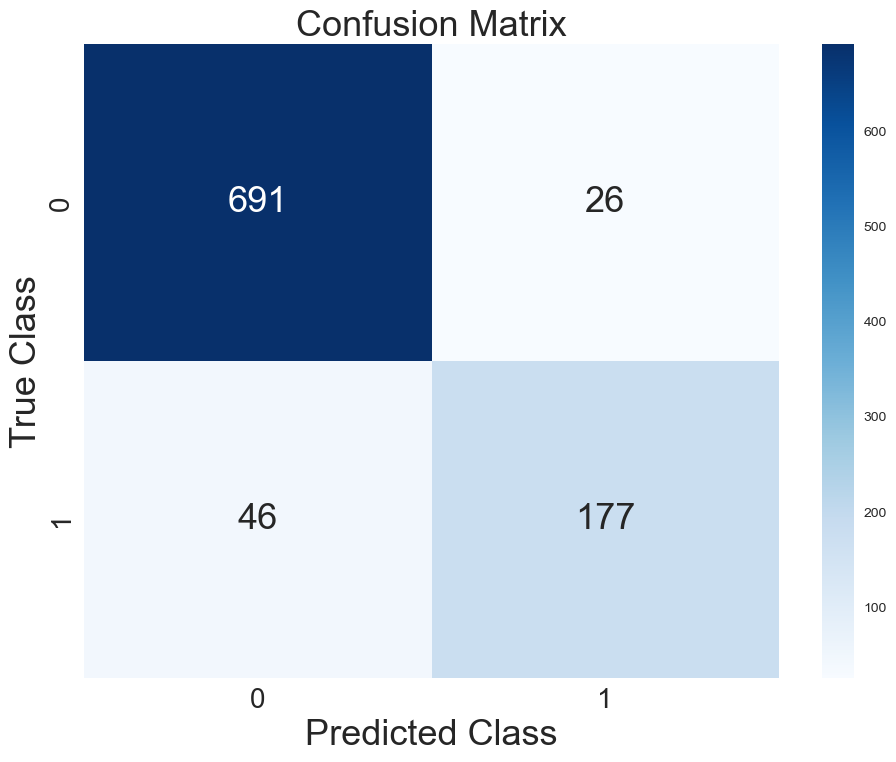

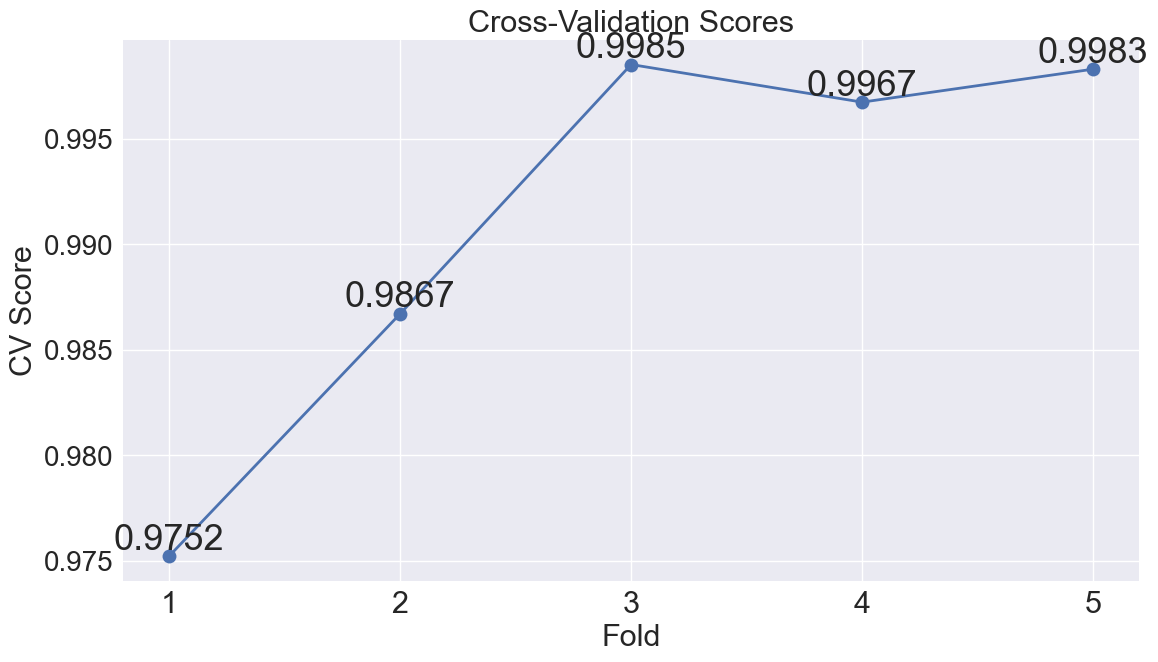

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')  # Using seaborn style for better aesthetics

# Confusion Matrix
true_negatives, false_positives, false_negatives, true_positives = [691, 26, 46, 177]

plt.figure(figsize=(10, 8))
conf_matrix_data = [[true_negatives, false_positives],
                    [false_negatives, true_positives]]
sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 26})
plt.xlabel("Predicted Class", fontsize=26)
plt.ylabel("True Class", fontsize=26)
plt.title("Confusion Matrix", fontsize=26)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

# Cross-validation scores
cv_scores = [0.97521464, 0.98669889, 0.99851271, 0.99672965, 0.998293]

plt.figure(figsize=(12, 7))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='-', linewidth=2, markersize=10)
plt.xticks(range(1, 6), fontsize=22)
plt.yticks(fontsize=20)
plt.xlabel("Fold", fontsize=22)
plt.ylabel("CV Score", fontsize=22)
plt.title("Cross-Validation Scores", fontsize=22)
plt.grid(True)
for i, score in enumerate(cv_scores):
    plt.text(i+1, score, f'{score:.4f}', ha='center', va='bottom', fontsize=26)
plt.tight_layout()
plt.savefig("cross_validation_scores.png", dpi=300, bbox_inches='tight')

# Print additional information
print("Feature Selector: SelectFromModel_GB, Classifier: LGBMClassifier")
print("\nClassification Report:")
print("              precision    recall  f1-score   support")
print("           0       0.94      0.96      0.95       717")
print("           1       0.87      0.79      0.83       223")
print("\n    accuracy                           0.92       940")
print("   macro avg       0.90      0.88      0.89       940")
print("weighted avg       0.92      0.92      0.92       940")

print("\nMean CV Score:", sum(cv_scores) / len(cv_scores))

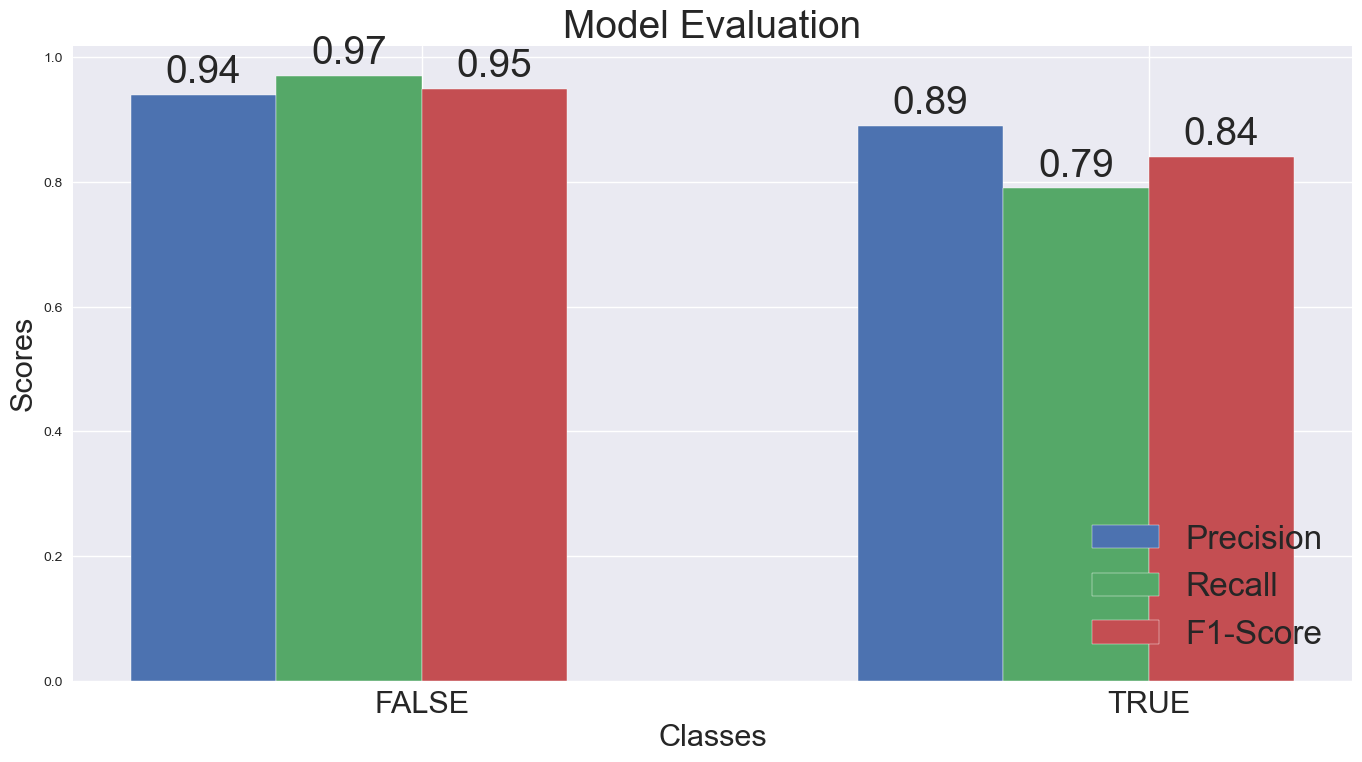

In [ ]:
import matplotlib.pyplot as plt
"""  
 AUC-ROC Score: 0.9328417484411256
Feature Selector: SelectFromModel_GB, Classifier: LGBM
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       717
           1       0.89      0.79      0.84       223

    accuracy                           0.93       940
   macro avg       0.92      0.88      0.90       940
weighted avg       0.93      0.93      0.93       940"""
# Data for metrics
classes = ['FALSE', 'TRUE']
precision = [0.94, 0.89]
recall = [0.97, 0.79]
f1_score = [0.95, 0.84]

# Plot settings
bar_width = 0.2
index = range(len(classes))
fig, ax = plt.subplots(figsize=(14, 8 ))  # Increased figure size

# Plotting the bars
bar1 = ax.bar(index, precision, bar_width, label='Precision')
bar2 = ax.bar([p + bar_width for p in index], recall, bar_width, label='Recall')
bar3 = ax.bar([p + 2 * bar_width for p in index], f1_score, bar_width, label='F1-Score')

# Add labels, title, and legend
ax.set_xlabel('Classes', fontsize=22)  # Increased font size
ax.set_ylabel('Scores', fontsize=22)  # Increased font size
ax.set_title('Model Evaluation', fontsize=28)  # Increased font size
ax.set_xticks([p + 1.5 * bar_width for p in index])
ax.set_xticklabels(classes, fontsize=22)  # Increased font size
ax.legend(fontsize=24, loc= "lower right")  # Increased font size

# Add bar values
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=28)  # Increased font size

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
#Calculando e exibindo o AUC-ROC score para classificação binária
auc_roc = roc_auc_score(y_test, probabilities)

print("AUC-ROC Score:", auc_roc)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming you have already calculated the probabilities and have y_test

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(y_test, probabilities)

# Create the ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.legend(loc="lower right", fontsize=18)

# Add AUC-ROC score text on the plot
#plt.text(0.7, 0.2, f'AUC-ROC Score: {auc_roc:.3f}', fontsize=18, bbox=dict(facecolor='white', alpha=0.5))

plt.grid(True)
plt.show()

# Print the AUC-ROC score
#print(f"AUC-ROC Score: {auc_roc:.3f}")

ValueError: Found input variables with inconsistent numbers of samples: [940, 3132]

In [ ]:
"""import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

# Supondo que df já exista e contenha dados

# Separando colunas numéricas e categóricas, excluindo certas colunas
exclude_cols = ["DIAS NA INSTITUICAO", "OBITO", "INT DES DESTINO", "INT DES DESTINO"]
numerical_cols = df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.difference(exclude_cols)

# Imputação
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

# Label Encoding para colunas categóricas
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Selecionando apenas as colunas que realmente existem no DataFrame
valid_categorical_cols = [col for col in categorical_cols if col in df.columns]
valid_numerical_cols = [col for col in numerical_cols if col in df.columns]
y = df["HIGH_RISK_DEATH"]
df = df.drop(["DIAS NA INSTITUICAO", "OBITO", "INT DES DESTINO", "INT DES DESTINO"], axis=1)

# Concatenando dados numéricos e categóricos codificados
df_encoded = df[valid_numerical_cols + valid_categorical_cols]

# Definindo X e y
X = df_encoded.drop(["HIGH_RISK_DEATH"], axis=1)

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicando SMOTE para balancear as classes no conjunto de treinamento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Normalizando os dados
scaler = MinMaxScaler()
X_train_resampled_normalized = scaler.fit_transform(X_train_resampled)
X_test_normalized = scaler.transform(X_test)

# Usando SelectFromModel com GradientBoostingClassifier para seleção de características
selector = SelectFromModel(estimator=GradientBoostingClassifier(), threshold=-np.inf, max_features=120)
selector.fit(X_train_resampled_normalized, y_train_resampled)
selected_features_indices = np.where(selector.get_support())[0]

# Usando os índices salvos para selecionar as características relevantes
X_train_selected = X_train_resampled_normalized[:, selected_features_indices]
X_test_selected = X_test_normalized[:, selected_features_indices]

# Definindo o pipeline
pipeline = Pipeline([
    ('selector', selector),
    ('classifier', LGBMClassifier())
])

# Definindo os parâmetros para o GridSearch
param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__num_leaves': [31, 50, 100]
}

# Realizando o GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_selected, y_train_resampled)

# Extraindo os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados pelo GridSearch:")
print(best_params)

# Treinando o modelo LGBMClassifier com as características selecionadas e os melhores parâmetros
best_classifier = grid_search.best_estimator_
predictions = best_classifier.predict(X_test_selected)
probabilities = best_classifier.predict_proba(X_test_selected)[:, 1]  # Para classificação binária

# Convertendo y_test para inteiro se necessário
y_test = y_test.astype(int)

# Calculando e exibindo o AUC-ROC score para classificação binária
auc_roc = roc_auc_score(y_test, probabilities)

print("AUC-ROC Score:", auc_roc)

# Exibindo os resultados
print("Feature Selector: SelectFromModel_GB, Classifier: LGBM")
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

# Realizando validação cruzada k-fold apenas no conjunto de treinamento
cv_scores = cross_val_score(best_classifier, X_train_selected, y_train_resampled, cv=5, scoring='roc_auc')

# Exibindo os resultados da validação cruzada
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))"""


'import pandas as pd\nimport numpy as np\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.feature_selection import SelectFromModel\nfrom sklearn.ensemble import GradientBoostingClassifier\nfrom sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score\nfrom sklearn.impute import SimpleImputer\nfrom imblearn.over_sampling import SMOTE\nfrom sklearn.preprocessing import MinMaxScaler\nfrom sklearn.metrics import classification_report, confusion_matrix, roc_auc_score\nfrom lightgbm import LGBMClassifier\nfrom sklearn.preprocessing import LabelEncoder\n\n# Supondo que df já exista e contenha dados\n\n# Separando colunas numéricas e categóricas, excluindo certas colunas\nexclude_cols = ["DIAS NA INSTITUICAO", "OBITO", "INT DES DESTINO", "INT DES DESTINO"]\nnumerical_cols = df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)\ncategorical_cols = df.select_dtypes(include=[\'object\', \'category\']).columns.difference(exclude_cols)\n\n# Imputação\nnum_

In [ ]:
"""import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Supondo que df já exista e contenha dados
# Separando colunas numéricas e categóricas, excluindo certas colunas
exclude_cols = ["DIAS NA INSTITUICAO", "OBITO", "INT DES DESTINO", "INT DES DESTINO"]
numerical_cols = df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.difference(exclude_cols)

# Imputação
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

# Label Encoding para colunas categóricas
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Selecionando apenas as colunas que realmente existem no DataFrame
valid_categorical_cols = [col for col in categorical_cols if col in df.columns]
valid_numerical_cols = [col for col in numerical_cols if col in df.columns]
y = df["HIGH_RISK_DEATH"]
df = df.drop(["DIAS NA INSTITUICAO", "OBITO", "INT DES DESTINO", "INT DES DESTINO"], axis=1)

# Concatenando dados numéricos e categóricos codificados
df_encoded = df[valid_numerical_cols + valid_categorical_cols]

# Definindo X e y
X = df_encoded.drop(["HIGH_RISK_DEATH"], axis=1)

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicando SMOTE para balancear as classes no conjunto de treinamento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Normalizando os dados
scaler = MinMaxScaler()
X_train_resampled_normalized = scaler.fit_transform(X_train_resampled)
X_test_normalized = scaler.transform(X_test)

# Definindo os algoritmos de seleção de características
feature_selectors = [
    ('RFE', RFE(estimator=RandomForestClassifier())),
    ('SelectFromModel_RF', SelectFromModel(estimator=RandomForestClassifier())),
    ('SelectFromModel_GB', SelectFromModel(estimator=GradientBoostingClassifier())),
    ('SelectFromModel_LR', SelectFromModel(estimator=LogisticRegression())),
    ('SelectFromModel_ET', SelectFromModel(estimator=ExtraTreesClassifier())),
    ('SelectFromModel_AB', SelectFromModel(estimator=AdaBoostClassifier())),
]

# Definindo os classificadores
classifiers = [
    ('RandomForest', RandomForestClassifier()),
    ('GradientBoosting', GradientBoostingClassifier()),
    ('SVM', SVC()),
    ('DecisionTree', DecisionTreeClassifier()),
    ('XGBoost', XGBClassifier()),
    ('LGBM', LGBMClassifier()),
    ('CatBoost', CatBoostClassifier(silent=True)),
    ('ExtraTrees', ExtraTreesClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('RidgeClassifier', RidgeClassifier()),
]

# Loop sobre os seletores de características e classificadores
for selector_name, selector in feature_selectors:
    for classifier_name, classifier in classifiers:
        # Criar um pipeline com seleção de características e classificador
        pipeline = Pipeline([
            ('selector', selector),
            ('classifier', classifier)
        ])

        # Ajustar o pipeline nos dados de treinamento
        pipeline.fit(X_train_resampled_normalized, y_train_resampled)

        # Prever nos dados de teste
        predictions = pipeline.predict(X_test_normalized)

        # Calcular e exibir o relatório de classificação e a matriz de confusão
        print("Feature Selector:", selector_name, ", Classifier:", classifier_name)
        print(classification_report(y_test, predictions))
        print(confusion_matrix(y_test, predictions))
        print("\n")
"""

'import pandas as pd\nimport numpy as np\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.feature_selection import RFE, SelectFromModel\nfrom sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier\nfrom sklearn.linear_model import LogisticRegression, RidgeClassifier\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn.svm import SVC\nfrom xgboost import XGBClassifier\nfrom catboost import CatBoostClassifier\nfrom lightgbm import LGBMClassifier\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.impute import SimpleImputer\nfrom imblearn.over_sampling import SMOTE\nfrom sklearn.preprocessing import MinMaxScaler, LabelEncoder\nfrom sklearn.metrics import classification_report, confusion_matrix\n\n# Supondo que df já exista e contenha dados\n# Separando colunas numéricas e categóricas, excluindo certas colunas\nexclude_cols = ["DIAS NA INSTITUICAO", "OBITO", "INT DES DESTINO", "INT DES DESTINO"]\nn

In [ ]:
""""import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
# Supondo que 'df' é seu DataFrame
# Supondo que 'DIAS NA INSTITUICAO_label' é sua variável alvo

# Separando colunas numéricas e categóricas, excluindo "DIAS NA INSTITUICAO" e "OBITO"
exclude_cols = ["DIAS NA INSTITUICAO", "OBITO", "INT DES DESTINO", "DIAS NA INSTITUICAO_label", "DIAS NA INSTITUICAO_CATEGORIA"]
numerical_cols = df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)
categorical_cols = df.select_dtypes(include=['category']).columns.difference(exclude_cols)

# Imputação apenas nas colunas numéricas
num_imputer = SimpleImputer(strategy='median')
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

# One-Hot Encoding para colunas categóricas
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_cats = encoder.fit_transform(df[categorical_cols])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenando dados numéricos e categóricos codificados
df_encoded = pd.concat([pd.DataFrame(df[numerical_cols], columns=numerical_cols), encoded_cat_df], axis=1)

# Utilizando diretamente o DataFrame codificado após imputação

# Dropping columns
X = df_encoded
y = df["DIAS NA INSTITUICAO_label"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


# Applying SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Normalizing the data
scaler = MinMaxScaler()
X_train_resampled_normalized = scaler.fit_transform(X_train_resampled)
X_test_normalized = scaler.transform(X_test)

# Defining the feature selection algorithms
feature_selectors = [
    ('RFE', RFE(estimator=RandomForestClassifier())),
    ('SelectFromModel_RF', SelectFromModel(estimator=RandomForestClassifier())),
    ('SelectFromModel_GB', SelectFromModel(estimator=GradientBoostingClassifier())),
    ('SelectFromModel_LR', SelectFromModel(estimator=LogisticRegression())),
    ('SelectFromModel_ET', SelectFromModel(estimator=ExtraTreesClassifier())),
    ('SelectFromModel_AB', SelectFromModel(estimator=AdaBoostClassifier())),
]

# Defining the classification models
classifiers = [
    ('RandomForest', RandomForestClassifier()),
    ('GradientBoosting', GradientBoostingClassifier()),
    ('SVM', SVC()),
    ('DecisionTree', DecisionTreeClassifier()),
    ('XGBoost', XGBClassifier()),
    ('LGBM', LGBMClassifier()),
    ('CatBoost', CatBoostClassifier(silent=True)),
    ('ExtraTrees', ExtraTreesClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('RidgeClassifier', RidgeClassifier()),
]

# Loop over feature selectors and classifiers
for selector_name, selector in feature_selectors:
    for classifier_name, classifier in classifiers:
        # Create a pipeline with feature selection and classifier
        pipeline = Pipeline([
            ('selector', selector),
            ('classifier', classifier)
        ])

        # Fit pipeline on the training data
        pipeline.fit(X_train_resampled_normalized, y_train_resampled)

        # Predict on the test data
        predictions = pipeline.predict(X_test_normalized)

        # Calculate and display classification report and confusion matrix
        print("Feature Selector:", selector_name, ", Classifier:", classifier_name)
        print(classification_report(y_test, predictions))
        print(confusion_matrix(y_test, predictions))
        print("\n")
"""

'"import pandas as pd\nimport numpy as np\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.feature_selection import RFE, SelectFromModel\nfrom sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier\nfrom sklearn.linear_model import LogisticRegression, RidgeClassifier\nfrom sklearn.svm import SVC\nfrom xgboost import XGBClassifier\nfrom lightgbm import LGBMClassifier\nfrom catboost import CatBoostClassifier\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn.model_selection import train_test_split, cross_val_score\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.preprocessing import MinMaxScaler\nfrom imblearn.over_sampling import SMOTE\nfrom sklearn.metrics import classification_report, confusion_matrix, roc_auc_score\nfrom sklearn.preprocessing import OneHotEncoder\n# Supondo que \'df\' é seu DataFrame\n# Supondo que \'DIAS NA INSTITUICAO_label\' é sua variável alvo\n\n# Separando colunas numéricas e c

In [ ]:
"""from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Supondo que df já exista e contenha dados

# Separando colunas numéricas e categóricas, excluindo certas colunas
exclude_cols = ["DIAS NA INSTITUICAO", "OBITO", "DIAS NA INSTITUICAO_label", "DIAS NA INSTITUICAO_CATEGORIA"]
numerical_cols = df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.difference(exclude_cols)

# Imputação
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

# Label Encoding para colunas categóricas
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


# Selecionando apenas as colunas que realmente existem no DataFrame
valid_categorical_cols = [col for col in categorical_cols if col in df.columns]
valid_numerical_cols = [col for col in numerical_cols if col in df.columns]

# Concatenando dados numéricos e categóricos codificados
df_encoded = df[valid_numerical_cols + valid_categorical_cols]


# Dropping columns
X = df_encoded
y = df["DIAS NA INSTITUICAO_label"]

# Creating an imputer that replaces NaN with the column's median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.25, random_state=42)

# Applying SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

# Create the scaler
scaler = MinMaxScaler()

# Apply normalization to the training and testing data
X_train_resampled_normalized = scaler.fit_transform(X_train_resampled)
X_test_resampled_normalized = scaler.transform(X_test_resampled)

# Defining the feature selection algorithms
feature_selectors = [
    ('RFE', RFE(estimator=RandomForestClassifier())),
    #('SelectKBest_chi2', SelectKBest(score_func=chi2)),
    #('SelectKBest_f_classif', SelectKBest(score_func=f_classif)),
    #('SelectKBest_mutual_info_classif', SelectKBest(score_func=mutual_info_classif)),
    ('SelectFromModel_RF', SelectFromModel(estimator=RandomForestClassifier())),
    ('SelectFromModel_GB', SelectFromModel(estimator=GradientBoostingClassifier())),
    ('SelectFromModel_LR', SelectFromModel(estimator=LogisticRegression())),
    ('SelectFromModel_ET', SelectFromModel(estimator=ExtraTreesClassifier())),
    ('SelectFromModel_AB', SelectFromModel(estimator=AdaBoostClassifier())),
]

# Defining the classification models
classifiers = [
    ('RandomForest', RandomForestClassifier()),
    ('GradientBoosting', GradientBoostingClassifier()),
    ('SVM', SVC()),
    ('DecisionTree', DecisionTreeClassifier()),
    #('LogisticRegression', LogisticRegression()),
    #('NaiveBayes', GaussianNB()),
    #('MLP', MLPClassifier()),
    ('XGBoost', XGBClassifier()),
    ('LGBM', LGBMClassifier()),
    ('CatBoost', CatBoostClassifier(silent=True)),
    ('ExtraTrees', ExtraTreesClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('RidgeClassifier', RidgeClassifier()),
]

# Creating pipelines to try different combinations of feature selection algorithms and classification models
for feature_selector_name, feature_selector in feature_selectors:
    for classifier_name, classifier in classifiers:
        pipeline = Pipeline([
            ('feature_selector', feature_selector),
            ('classifier', classifier)
        ])
        pipeline.fit(X_train_resampled_normalized, y_train_resampled)
        predictions = pipeline.predict(X_test_resampled_normalized)
        print(f"Feature Selector: {feature_selector_name}, Classifier: {classifier_name}")
        print(classification_report(y_test_resampled, predictions))
        print(confusion_matrix(y_test_resampled, predictions))"""

'from sklearn.pipeline import Pipeline\nfrom sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif, mutual_info_classif\nfrom sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier\nfrom sklearn.svm import SVC\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn.linear_model import LogisticRegression, RidgeClassifier\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.naive_bayes import GaussianNB\nfrom sklearn.neural_network import MLPClassifier\nfrom xgboost import XGBClassifier\nfrom lightgbm import LGBMClassifier\nfrom catboost import CatBoostClassifier\nfrom sklearn.metrics import classification_report, confusion_matrix\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.impute import SimpleImputer\nfrom imblearn.over_sampling import SMOTE\nimport pandas as pd\nfrom sklearn.preprocessing import MinMaxScaler\nimport pandas as pd\nimport numpy as np\nfr

In [ ]:
"""from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from xgboost import XGBClassifier

# Dropping columns
X = df.drop(["DIAS INSTITUICAO LABEL", "DIAS NA INSTITUICAO", "DIAS NA INSTITUICAO_CATEGORIA"], axis=1)
y = df["DIAS INSTITUICAO LABEL"]

# Creating an imputer that replaces NaN with the column's median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.25, random_state=42)

# Applying SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

# Normalizing the data
scaler = MinMaxScaler()
X_train_resampled_normalized = scaler.fit_transform(X_train_resampled)
X_test_resampled_normalized = scaler.transform(X_test_resampled)

# Define the pipeline with SelectFromModel and RandomForestClassifier for feature selection
pipeline = Pipeline([
    ('feature_selection', SelectFromModel(estimator=RandomForestClassifier(random_state=42))),
    ('classification', XGBClassifier())
])

# Define the grid of parameters to search
param_grid = {
    'feature_selection__estimator__n_estimators': [10, 30, 50, 70, 100],
    'classification__n_estimators': [50, 100, 130],
    'classification__learning_rate': [0.01, 0.1, 0.2],
    'classification__max_depth': [3, 5, 10],
    'classification__min_child_weight': [1, 2, 4]
}

# Configure the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Train the GridSearchCV
grid_search.fit(X_train_resampled_normalized, y_train_resampled)

# Get the best parameters and best model
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados: ", best_params)
best_model = grid_search.best_estimator_

# Get the selected features using the best model
rfe = best_model.named_steps['feature_selection']
selected_features_indices = np.where(rfe.get_support())[0]

# Use the selected features for the XGBClassifier
X_train_selected = X_train_resampled_normalized[:, selected_features_indices]
X_test_selected = X_test_resampled_normalized[:, selected_features_indices]

# Train the GradientBoostingClassifier model with the selected features
classifier = best_model.named_steps['classification']
classifier.fit(X_train_selected, y_train_resampled)
predictions = classifier.predict(X_test_selected)
probabilities = classifier.predict_proba(X_test_selected)

# Calculate and display the AUC-ROC score for multi-class
auc_roc = roc_auc_score(y_test_resampled, probabilities, multi_class='ovr')
print("AUC-ROC Score:", auc_roc)

# Displaying the results
print("Feature Selector: SelectFromModel with RandomForest, Classifier: XGBClassifier")
print(classification_report(y_test_resampled, predictions))
print(confusion_matrix(y_test_resampled, predictions))

# Performing k-fold cross-validation on the training set only
Xjoined_array = np.concatenate((X_train_selected, X_test_selected), axis=0)
yjoined_array = np.concatenate((y_train_resampled, y_test_resampled), axis=0)
#cv_scores = cross_val_score(classifier, Xjoined_array, yjoined_array, cv=5, scoring='roc_auc_ovr')

# Displaying cross-validation results
#print("Cross-Validation Scores:", cv_scores)
#print("Mean CV Score:", np.mean(cv_scores))
"""

'from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.feature_selection import SelectFromModel\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import train_test_split, GridSearchCV\nfrom sklearn.impute import SimpleImputer\nfrom imblearn.over_sampling import SMOTE\nimport pandas as pd\nfrom sklearn.preprocessing import MinMaxScaler\nimport numpy as np\nfrom xgboost import XGBClassifier\n\n# Dropping columns\nX = df.drop(["DIAS INSTITUICAO LABEL", "DIAS NA INSTITUICAO", "DIAS NA INSTITUICAO_CATEGORIA"], axis=1)\ny = df["DIAS INSTITUICAO LABEL"]\n\n# Creating an imputer that replaces NaN with the column\'s median\nimputer = SimpleImputer(strategy=\'median\')\nX_imputed = imputer.fit_transform(X)\n\n# Splitting the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.25, random_state=42)\n\n# Applying SMOTE to b

In [ ]:
cv_scores

[0.97521464, 0.98669889, 0.99851271, 0.99672965, 0.998293]

In [ ]:
"""import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
categorical_cols = df.select_dtypes(include=['object', 'category'])#.columns.difference(exclude_cols)

# Label Encoding para colunas categóricas
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Definindo X e y
X = df.drop(["RISK_DEATH", "DTA NASC_ano", "DIAS NA INSTITUICAO", "OBITO", "INT DES DESTINO", "4_IDADE"], axis=1)
y = df["RISK_DEATH"]
# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Aplicando SMOTE para balancear as classes no conjunto de treinamento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Normalizando os dados
scaler = MinMaxScaler()
X_train_resampled_normalized = scaler.fit_transform(X_train_resampled)
X_test_normalized = scaler.transform(X_test)

# Usando SelectFromModel com GradientBoostingClassifier para seleção de características
selector = SelectFromModel(estimator=GradientBoostingClassifier(), threshold=-np.inf, max_features=11)
selector.fit(X_train_resampled_normalized, y_train_resampled)
selected_features_indices = np.where(selector.get_support())[0]

# Usando os índices salvos para selecionar as características relevantes
X_train_selected = X_train_resampled_normalized[:, selected_features_indices]
X_test_selected = X_test_normalized[:, selected_features_indices]
class_weights=  {0: 1, 1: 1}

base_learners = [
    ('gbt', GradientBoostingClassifier(n_estimators=100, subsample=0.8, max_features=0.8, random_state=42)),   
    ('DecisionTree', DecisionTreeClassifier()),
    ('XGBoost', XGBClassifier()),
    ('CatBoost', CatBoostClassifier(silent=True)),]

meta_classifier = classifier = LGBMClassifier(class_weight=  class_weights,learning_rate=0.8, max_depth=6, n_estimators=20, num_leaves=20)
# Treinando o modelo LGBMClassifier com os melhores hiperparâmetros

stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_classifier, cv=5, stack_method='predict_proba')

stacking_model.fit(X_train_selected, y_train_resampled)
predictions = stacking_model.predict(X_test_selected)
probabilities = stacking_model.predict_proba(X_test_selected)[:, 1]  # Para classificação binária

# Convertendo y_test para inteiro se necessário
y_test = y_test.astype(int)

# Calculando e exibindo o AUC-ROC score para classificação binária
auc_roc = roc_auc_score(y_test, probabilities)

print("AUC-ROC Score:", auc_roc)

# Exibindo os resultados
print("Feature Selector: SelectFromModel_GB, Classifier: LGBM")
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

# Realizando validação cruzada k-fold apenas no conjunto de treinamento
cv_scores = cross_val_score(classifier, X_train_selected, y_train_resampled, cv=5, scoring='roc_auc')

# Exibindo os resultados da validação cruzada
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))"""

'import pandas as pd\nimport numpy as np\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.feature_selection import SelectFromModel\nfrom sklearn.ensemble import GradientBoostingClassifier\nfrom sklearn.model_selection import train_test_split, cross_val_score\nfrom sklearn.impute import SimpleImputer\nfrom imblearn.over_sampling import SMOTE\nfrom sklearn.preprocessing import MinMaxScaler\nfrom sklearn.metrics import classification_report, confusion_matrix, roc_auc_score\nfrom lightgbm import LGBMClassifier\nfrom sklearn.preprocessing import LabelEncoder\nfrom sklearn.tree import DecisionTreeClassifier\nfrom xgboost import XGBClassifier\nfrom catboost import CatBoostClassifier\nfrom lightgbm import LGBMClassifier\nfrom sklearn.ensemble import StackingClassifier\ncategorical_cols = df.select_dtypes(include=[\'object\', \'category\'])#.columns.difference(exclude_cols)\n\n# Label Encoding para colunas categóricas\nlabel_encoders = {}\nfor col in categorical_cols:\n    le = LabelEncoder

In [ ]:
"""import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier

categorical_cols = df.select_dtypes(include=['object', 'category'])#.columns.difference(exclude_cols)

# Label Encoding para colunas categóricas
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Definindo X e y
X = df.drop([ "RISK_DEATH", "DTA NASC_ano", "DIAS NA INSTITUICAO", "OBITO", "INT DES DESTINO", "4_IDADE"], axis=1)
y = df["RISK_DEATH"]
# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Aplicando SMOTE para balancear as classes no conjunto de treinamento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Normalizando os dados
scaler = MinMaxScaler()
X_train_resampled_normalized = scaler.fit_transform(X_train_resampled)
X_test_normalized = scaler.transform(X_test)

# Usando SelectFromModel com GradientBoostingClassifier para seleção de características
selector = SelectFromModel(estimator=GradientBoostingClassifier(), threshold=-np.inf, max_features=11)
selector.fit(X_train_resampled_normalized, y_train_resampled)
selected_features_indices = np.where(selector.get_support())[0]

# Usando os índices salvos para selecionar as características relevantes
X_train_selected = X_train_resampled_normalized[:, selected_features_indices]
X_test_selected = X_test_normalized[:, selected_features_indices]
class_weights=  {0: 1, 1: 1}

base_learners = [
    ('gbt', GradientBoostingClassifier(n_estimators=100, subsample=0.8, max_features=0.8, random_state=42)),   
    ('DecisionTree', DecisionTreeClassifier()),
    ('XGBoost', XGBClassifier()),
    ('CatBoost', CatBoostClassifier(silent=True)),]

meta_classifier = classifier = LGBMClassifier(class_weight=  class_weights,learning_rate=0.8, max_depth=6, n_estimators=20, num_leaves=20)
# Treinando o modelo LGBMClassifier com os melhores hiperparâmetros

stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_classifier, cv=5, stack_method='predict_proba')

stacking_model.fit(X_train_selected, y_train_resampled)
predictions = stacking_model.predict(X_test_selected)
probabilities = stacking_model.predict_proba(X_test_selected)[:, 1]  # Para classificação binária

# Convertendo y_test para inteiro se necessário
y_test = y_test.astype(int)

# Calculando e exibindo o AUC-ROC score para classificação binária
auc_roc = roc_auc_score(y_test, probabilities)

print("AUC-ROC Score:", auc_roc)

# Exibindo os resultados
print("Feature Selector: SelectFromModel_GB, Classifier: LGBM")
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

# Realizando validação cruzada k-fold apenas no conjunto de treinamento
cv_scores = cross_val_score(classifier, X_train_selected, y_train_resampled, cv=5, scoring='roc_auc')

# Exibindo os resultados da validação cruzada
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))"""

'import pandas as pd\nimport numpy as np\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.feature_selection import SelectFromModel\nfrom sklearn.ensemble import GradientBoostingClassifier\nfrom sklearn.model_selection import train_test_split, cross_val_score\nfrom sklearn.impute import SimpleImputer\nfrom imblearn.over_sampling import SMOTE\nfrom sklearn.preprocessing import MinMaxScaler\nfrom sklearn.metrics import classification_report, confusion_matrix, roc_auc_score\nfrom lightgbm import LGBMClassifier\nfrom sklearn.preprocessing import LabelEncoder\nfrom sklearn.tree import DecisionTreeClassifier\nfrom xgboost import XGBClassifier\nfrom catboost import CatBoostClassifier\nfrom lightgbm import LGBMClassifier\nfrom sklearn.ensemble import StackingClassifier\nimport numpy as np\nfrom sklearn.feature_selection import SelectFromModel\nfrom sklearn.ensemble import GradientBoostingClassifier\nfrom sklearn.model_selection import train_test_split, cross_val_score\nfrom sklearn.impute i